# Multivariate Gaussian

Use PyMC3 to fit a [Multivariate Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution).

Based on: http://docs.pymc.io/notebooks/LKJ.html

In [1]:
import warnings
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns

import scipy.stats as stats
import theano.tensor as T
import pymc3 as pm

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
def generate_surface(mean, covariance, d):
    """Helper function to generate surface to plot."""
    nb_of_x = 100 # compute the cost nb_of_ws times in each dimension
    x1s = np.linspace(-5, 5, num=nb_of_x) # hidden weights
    x2s = np.linspace(-5, 5, num=nb_of_x) # output weights
    x1, x2 = np.meshgrid(x1s, x2s) # generate grid
    x = np.hstack((x1.reshape(10000, 1), x2.reshape(10000, 1)))
    p = stats.multivariate_normal.pdf(x, mean=mean, cov=covariance)
    p = p.reshape(100, 100)
    return x1, x2, p

def make_ellipse(mu, cov, ci=0.95, color='gray', label='95% ci'):
    e, v = np.linalg.eig(cov)
    angle = 180/np.pi * np.arccos(v[0, 0])
    q = stats.chi2(2).ppf(ci)
    e = Ellipse(mu, 2*np.sqrt(q*e[0]), 2*np.sqrt(q*e[1]), angle=angle, fill=False, color=color, label=label)
    return e

[Sample from a Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution) with the help of the [Cholesky decompostion](https://en.wikipedia.org/wiki/Cholesky_decomposition).

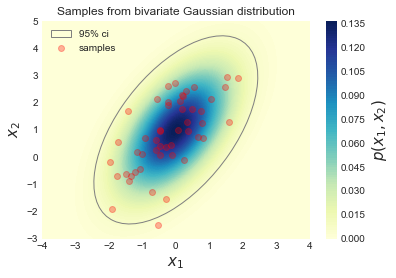

In [3]:
np.random.seed(42)
# Sample from:
d = 2 # Number of dimensions
mean = np.array([0, 1])
covariance = np.matrix([[1, 0.8], [0.8, 2]])
n = 50  # Samples to draw

# Create L
L = np.linalg.cholesky(covariance)
# Sample from standard normal
x_stdnormal = np.random.normal(size=(d, n))
# Apply the transformation
data = (mean + L.dot(x_stdnormal).T)

# Plot the samples and the distribution
fig, ax = plt.subplots()
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
# Plot 95% Interval
e = make_ellipse(mean, covariance)
ax.add_artist(e)
# Plot samples
s, = ax.plot(data[:,0], data[:,1], 'ro', alpha=.3, label='samples')
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.axis([-4, 4, -3, 5])
ax.set_title('Samples from bivariate Gaussian distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=15)
plt.legend(handles=[e, s], loc=2)
plt.show()

In [4]:
with pm.Model() as model:
    sd_dist = pm.HalfCauchy.dist(beta=10)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=d, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    mu = pm.Normal('mu', mu=0., sd=10., shape=d)
    obs = pm.MvNormal('obs', mu, chol=chol, observed=data)

print('packed_chol: ', packed_chol.tag.test_value.shape)
print('chol: ', chol.tag.test_value.shape)
print('cov: ', cov.tag.test_value.shape)
print('mu: ', mu.tag.test_value.shape)

packed_chol:  (3,)
chol:  (2, 2)
cov:  (2, 2)
mu:  (2,)


In [5]:
# Run inference
niter = 5000
with model:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(niter, step=step, start=start, random_seed=42, progressbar=True)

logp = -150.85, ||grad|| = 0.36627: 100%|██████████| 17/17 [00:00<00:00, 1036.76it/s] 
100%|██████████| 5500/5500 [00:14<00:00, 392.68it/s]


real mu:  [0 1]
real chol:  [[ 1.          0.          0.8         1.16619038]]


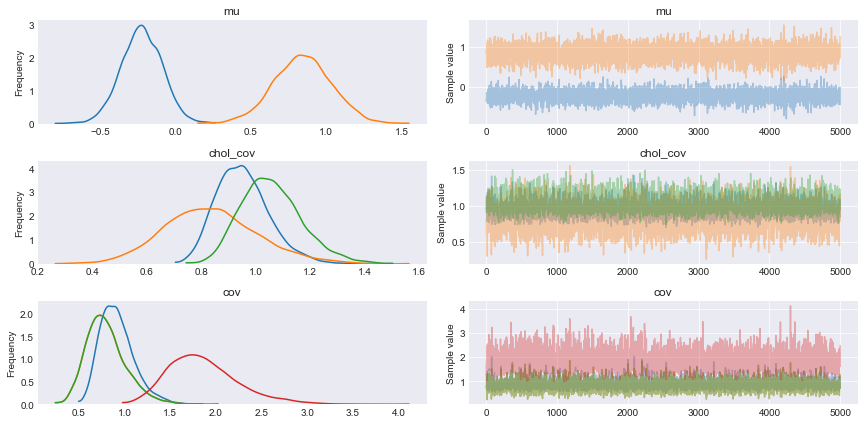

In [6]:
print('real mu: ', mean)
print('real chol: ', L.flatten())
pm.traceplot(trace)
plt.show()

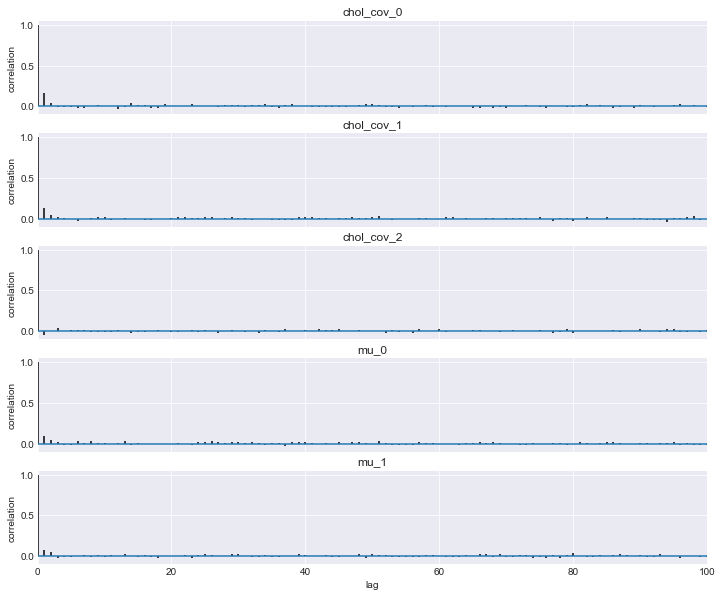

In [7]:
pm.autocorrplot(trace, varnames=['chol_cov', 'mu'])
plt.show()

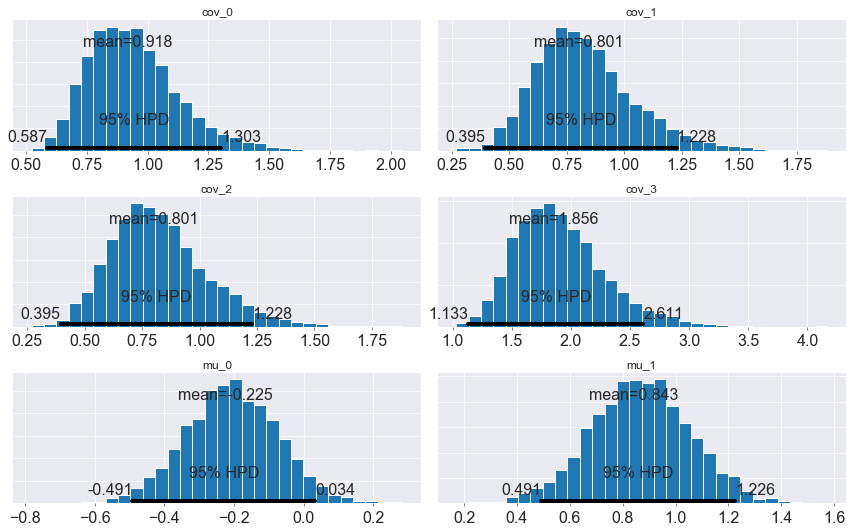

In [8]:
pm.plot_posterior(trace, varnames=['cov', 'mu'])
plt.show()

In [9]:
# Compare real mu with posterior mu with frequentist mu
mu_post = trace['mu'].mean(axis=0)
print('mu real: ', mean)
print('mu post: ', mu_post)
mu_freq = np.mean(data, axis=0)
print('mu freq: ', mu_freq)
print('')

# Compare real cov with posterior cov with frequentist cov
cov_post = trace['cov'].mean(axis=0)
print('cov real: ', covariance.flatten())
print('cov post: ', cov_post.flatten())
cov_freq = np.cov(data, rowvar=False)
print('cov freq: ', cov_freq.flatten())

mu real:  [0 1]
mu post:  [-0.22501458  0.84326418]
mu freq:  [[-0.22547391  0.84035676]]

cov real:  [[ 1.   0.8  0.8  2. ]]
cov post:  [ 0.91755993  0.80061074  0.80061074  1.85618664]
cov freq:  [ 0.87173739  0.80217783  0.80217783  1.76521668]


In [10]:
# Sample from the posterior
with model:
    posterior_trace = pm.sample_ppc(trace, samples=1000, random_seed=42)

100%|██████████| 1000/1000 [00:00<00:00, 3915.19it/s]


Samples from posterior:  (1000, 2)


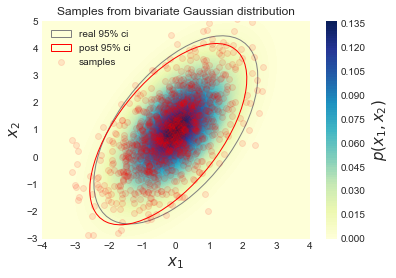

In [11]:
print('Samples from posterior: ', posterior_trace['obs'].shape)

# Plot the samples and the distribution
fig, ax = plt.subplots()
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
# Plot 95% Interval
e1 = make_ellipse(mean, covariance, color='grey', label='real 95% ci')
ax.add_artist(e1)
e2 = make_ellipse(mu_post, cov_post, color='red', label='post 95% ci')
ax.add_artist(e2)
# Plot samples
s, = plt.plot(posterior_trace['obs'][:,0], posterior_trace['obs'][:,1], 'ro', alpha=.1, label='samples')
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.axis([-4, 4, -3, 5])
ax.set_title('Samples from bivariate Gaussian distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=15)
plt.legend(handles=[e1, e2, s], loc=2)
plt.show()